##Loading Packages


In [16]:
install.packages(c("forecast", "ggplot2", "dplyr", "tseries", "lubridate"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Loading Data

In [18]:
library(readr)
library(lubridate)
library(dplyr)

# Reload CSV and read OCCUR_DATE as character
data <- read_csv("NYPD_Shooting_Incident_Data__Year_To_Date__20241215.csv",
                 col_types = cols(OCCUR_DATE = col_character()))

# Clean OCCUR_DATE: replace '-' with '/'
data$OCCUR_DATE <- gsub("-", "/", data$OCCUR_DATE)

# Parse OCCUR_DATE into proper date format (MM/DD/YYYY)
data$OCCUR_DATE <- mdy(data$OCCUR_DATE)

# Verify the conversion
summary(data$OCCUR_DATE)

# Remove rows with invalid/missing dates
data <- data %>% filter(!is.na(OCCUR_DATE))

# Check cleaned data
head(data)


Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2024-01-01" "2024-03-25" "2024-06-02" "2024-05-26" "2024-07-28" "2024-09-30"

INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,⋯,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
<dbl>,<date>,<time>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
290852778,2024-07-30,00:20:00,BROOKLYN,OUTSIDE,70,0,STREET,(null),N,⋯,(null),(null),18-24,M,BLACK,991549,169019,NA,NA,NA
289679504,2024-07-06,22:00:00,QUEENS,OUTSIDE,101,0,STREET,(null),N,⋯,M,BLACK,25-44,M,BLACK,1049528,157677,40.59922,-73.76493,POINT (-73.764932 40.599224)
293944629,2024-09-26,04:03:00,BRONX,OUTSIDE,46,0,STREET,(null),N,⋯,(null),(null),18-24,M,WHITE HISPANIC,1011755,250279,NA,NA,NA
287671763,2024-05-29,23:13:00,BRONX,OUTSIDE,52,0,STREET,(null),N,⋯,M,BLACK,25-44,M,BLACK HISPANIC,1017478,256069,NA,NA,NA
289287083,2024-06-28,20:55:00,QUEENS,OUTSIDE,107,2,HOUSING,MULTI DWELL - PUBLIC HOUS,N,⋯,(null),(null),18-24,F,BLACK,1035601,207363,40.73569,-73.81471,POINT (-73.814705 40.735693)
292648950,2024-09-02,14:30:00,BROOKLYN,OUTSIDE,77,0,STREET,(null),Y,⋯,(null),(null),25-44,M,BLACK,995441,183745,40.67101,-73.95965,POINT (-73.959655 40.671008)


## Sorting the data

In [19]:
library(dplyr)

# Group by OCCUR_DATE and count incidents
daily_data <- data %>%
  group_by(OCCUR_DATE) %>%
  summarise(incidents = n())

# View the aggregated data
head(daily_data)


OCCUR_DATE,incidents
<date>,<int>
2024-01-01,9
2024-01-02,2
2024-01-04,2
2024-01-06,5
2024-01-07,5
2024-01-08,3


## Identifying the days with 0 incidents

In [20]:
# Generate a sequence of all dates
all_dates <- data.frame(OCCUR_DATE = seq(min(daily_data$OCCUR_DATE),
                                        max(daily_data$OCCUR_DATE),
                                        by = "day"))

# Join and fill missing dates with 0 incidents
final_data <- all_dates %>%
  left_join(daily_data, by = "OCCUR_DATE") %>%
  mutate(incidents = ifelse(is.na(incidents), 0, incidents))

# Verify the final cleaned dataset
head(final_data)


,OCCUR_DATE,incidents
,<date>,<dbl>
1,2024-01-01,9
2,2024-01-02,2
3,2024-01-03,0
4,2024-01-04,2
5,2024-01-05,0
6,2024-01-06,5


## Data Plot

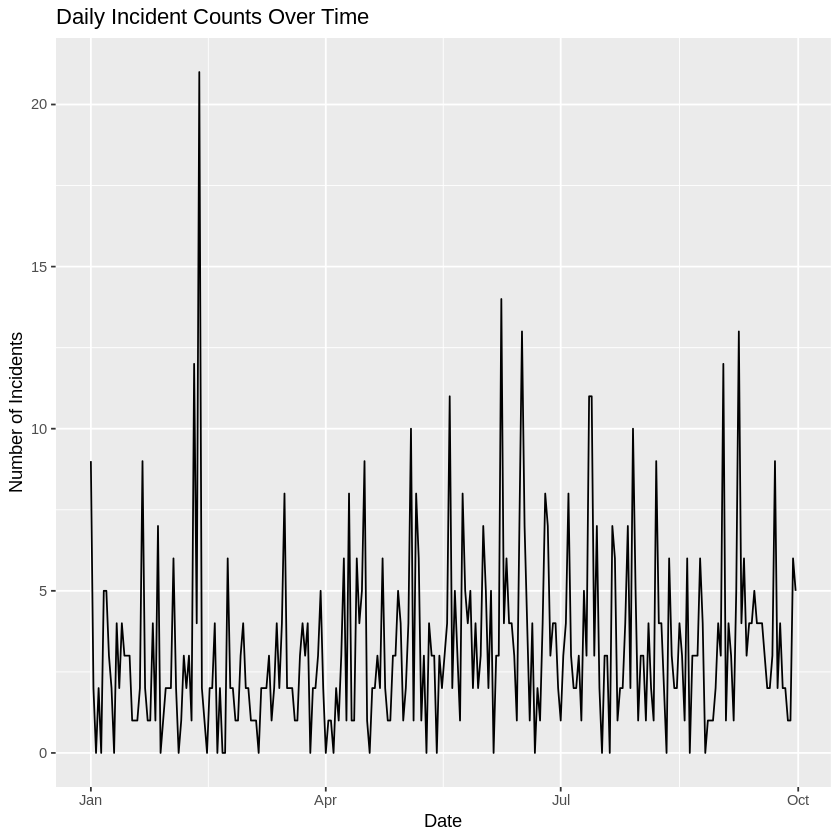

In [21]:
library(ggplot2)

ggplot(final_data, aes(x = OCCUR_DATE, y = incidents)) +
  geom_line() +
  ggtitle("Daily Incident Counts Over Time") +
  xlab("Date") +
  ylab("Number of Incidents")



In [22]:
summary(final_data)


   OCCUR_DATE           incidents     
 Min.   :2024-01-01   Min.   : 0.000  
 1st Qu.:2024-03-09   1st Qu.: 1.000  
 Median :2024-05-16   Median : 3.000  
 Mean   :2024-05-16   Mean   : 3.303  
 3rd Qu.:2024-07-23   3rd Qu.: 4.000  
 Max.   :2024-09-30   Max.   :21.000  

##Incidents by months

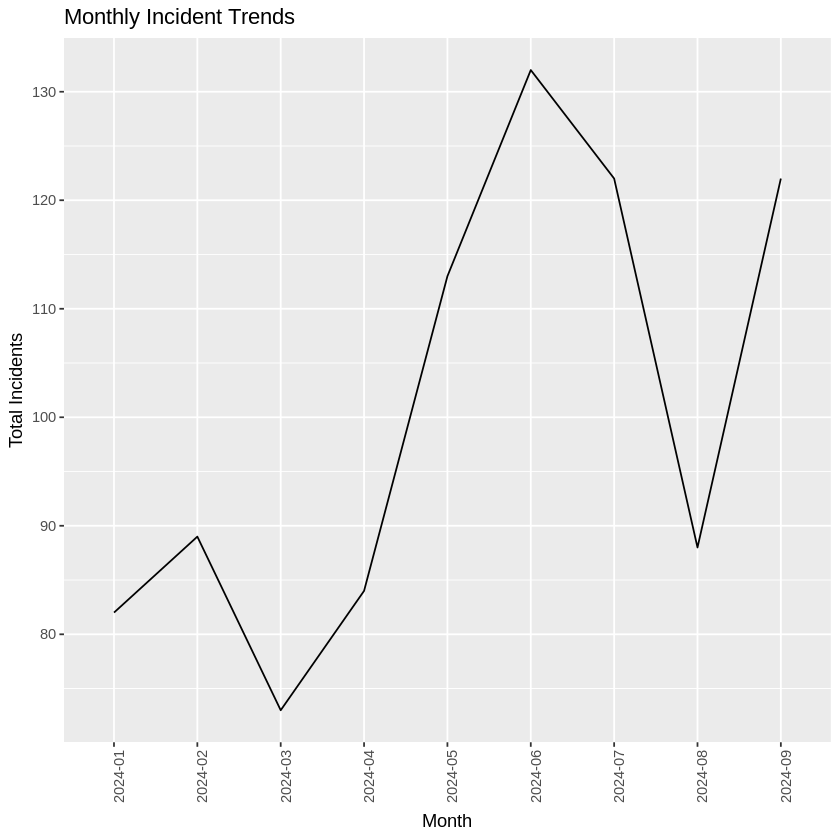

In [23]:
library(dplyr)
library(ggplot2)

# Aggregate by month
monthly_data <- final_data %>%
  mutate(month = format(OCCUR_DATE, "%Y-%m")) %>%
  group_by(month) %>%
  summarise(total_incidents = sum(incidents))

# Plot monthly trend
ggplot(monthly_data, aes(x = month, y = total_incidents, group = 1)) +
  geom_line() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("Monthly Incident Trends") +
  xlab("Month") +
  ylab("Total Incidents")


###Incidents Frequency

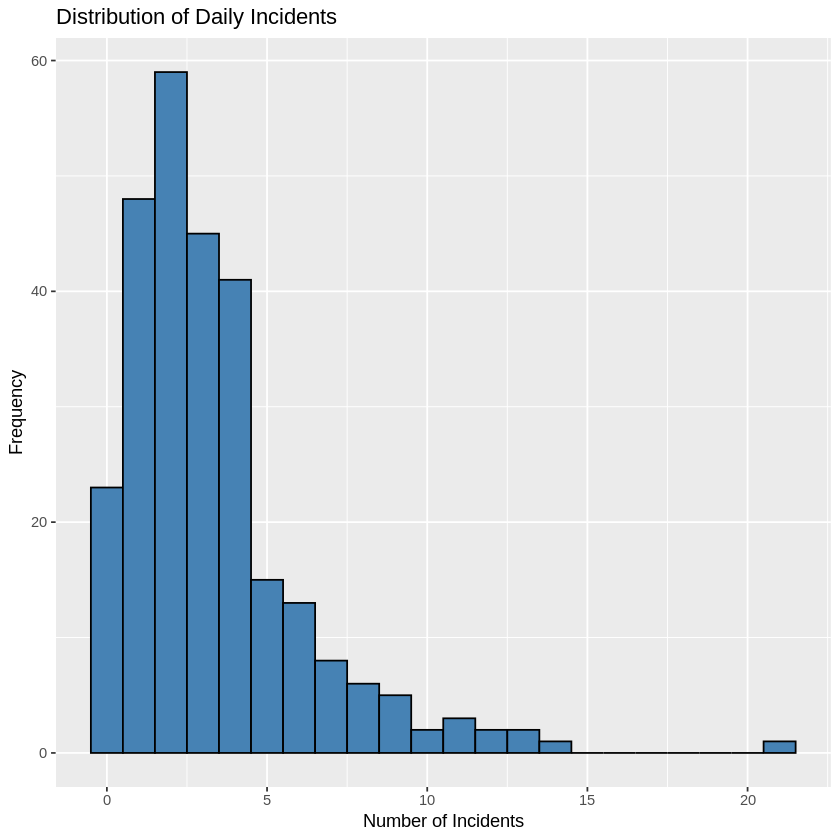

In [24]:
# Histogram of daily incidents
ggplot(final_data, aes(x = incidents)) +
  geom_histogram(binwidth = 1, fill = "steelblue", color = "black") +
  ggtitle("Distribution of Daily Incidents") +
  xlab("Number of Incidents") +
  ylab("Frequency")


##Outliers

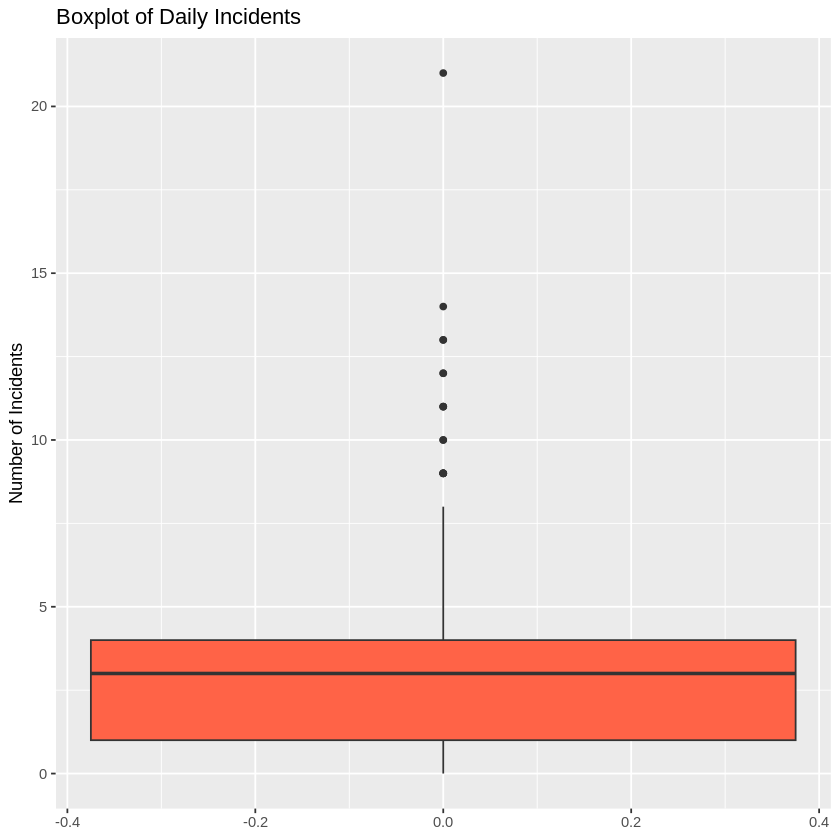

In [25]:
# Boxplot for outlier detection
ggplot(final_data, aes(y = incidents)) +
  geom_boxplot(fill = "tomato") +
  ggtitle("Boxplot of Daily Incidents") +
  ylab("Number of Incidents")


##ADF-Test

In [26]:
library(tseries)

# Perform ADF test on the incidents column
adf_result <- adf.test(final_data$incidents)

# Print the result
print(adf_result)


Warning message in adf.test(final_data$incidents):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  final_data$incidents
Dickey-Fuller = -6.5184, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



##Introducing MA

In [27]:
library(zoo)

# Step 1: Handle initial missing values with linear interpolation
final_data$incidents_imputed <- na.approx(final_data$incidents, rule = 2)

# Step 2: Apply rollapply with 'fill = NA' to ensure consistent row count
rolling_avg <- rollapply(final_data$incidents_imputed,
                         width = 7,
                         FUN = mean,
                         align = "center",
                         fill = NA)

# Step 3: Ensure the rolling average output matches the row count of final_data
final_data$incidents_imputed <- rolling_avg

# Step 4: Handle edge NAs with forward and backward filling
final_data$incidents_imputed <- na.locf(final_data$incidents_imputed, na.rm = FALSE, fromLast = FALSE)
final_data$incidents_imputed <- na.locf(final_data$incidents_imputed, na.rm = FALSE, fromLast = TRUE)

# Step 5: Validation
cat("Number of rows in final_data:", nrow(final_data), "\n")
cat("Number of rows in incidents_imputed:", length(final_data$incidents_imputed), "\n")

# Display final data for confirmation
head(final_data)


Number of rows in final_data: 274 
Number of rows in incidents_imputed: 274 


,OCCUR_DATE,incidents,incidents_imputed
,<date>,<dbl>,<dbl>
1,2024-01-01,9,3.285714
2,2024-01-02,2,3.285714
3,2024-01-03,0,3.285714
4,2024-01-04,2,3.285714
5,2024-01-05,0,2.428571
6,2024-01-06,5,2.428571


In [28]:
sum(is.na(final_data$incidents_imputed))

[1] 0

##Original Data vs Imputed Data

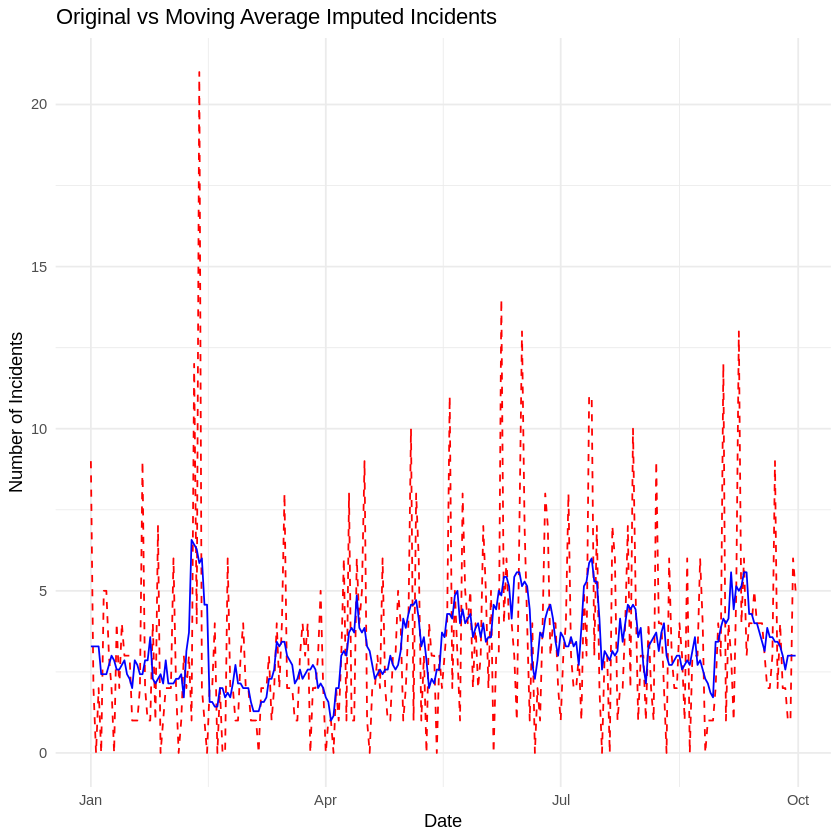

In [29]:
# Plot the original and imputed incidents
library(ggplot2)

ggplot(final_data, aes(x = OCCUR_DATE)) +
  geom_line(aes(y = incidents), color = "red", linetype = "dashed", na.rm = TRUE) +
  geom_line(aes(y = incidents_imputed), color = "blue") +
  ggtitle("Original vs Moving Average Imputed Incidents") +
  ylab("Number of Incidents") +
  xlab("Date") +
  theme_minimal()


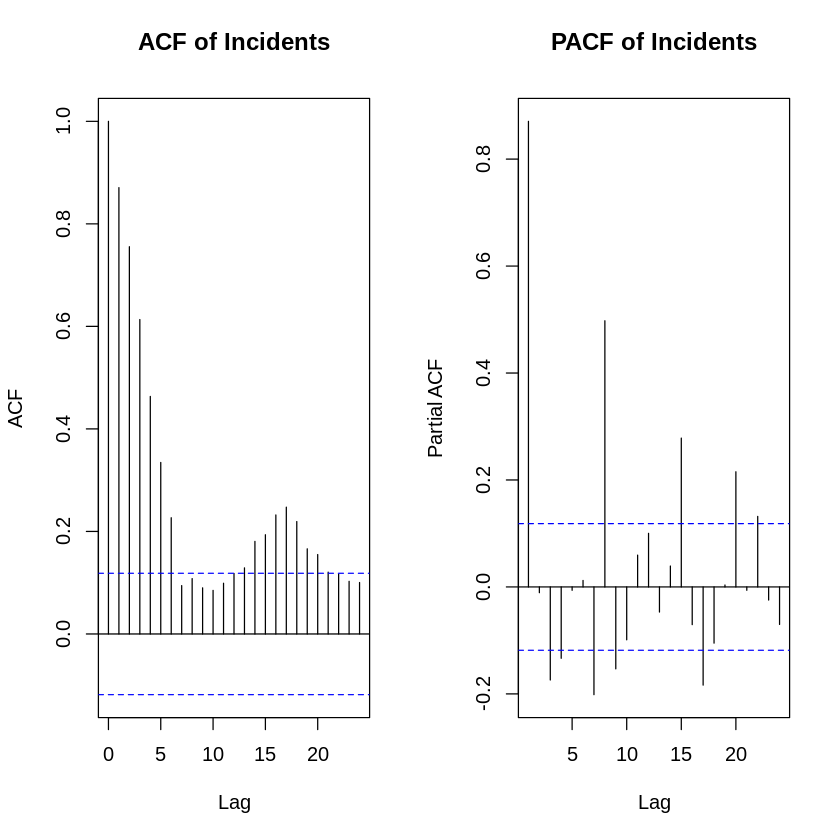

In [30]:
# Load required libraries
library(forecast)
library(tseries)

# ACF and PACF plots for incidents data
par(mfrow = c(1, 2))  # To display side-by-side
acf(final_data$incidents_imputed, main = "ACF of Incidents")
pacf(final_data$incidents_imputed, main = "PACF of Incidents")


##KPSS Test as we observe a differencing pattern in the ACF and PACF plots

In [31]:
library(tseries)

# Perform the KPSS test
kpss_test <- kpss.test(final_data$incidents_imputed)

# Print the result
print(kpss_test)


Warning message in kpss.test(final_data$incidents_imputed):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  final_data$incidents_imputed
KPSS Level = 1.039, Truncation lag parameter = 5, p-value = 0.01



In [35]:
# Convert to time series
incidents_data <- ts(final_data$incidents_imputed)

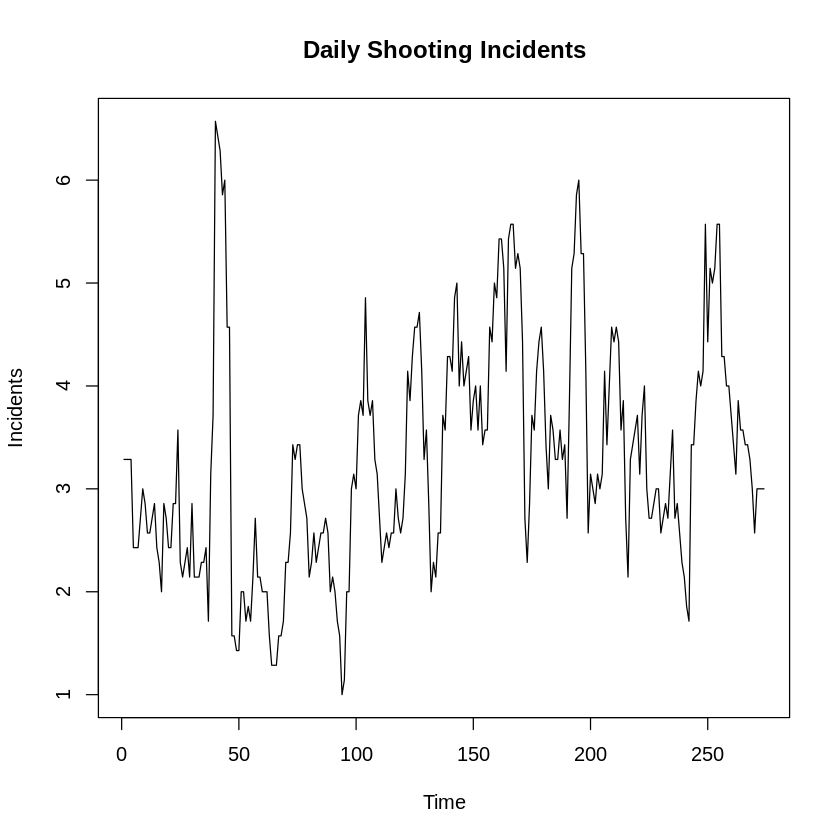

In [36]:
# Original time series
plot(incidents_data, main = "Daily Shooting Incidents", ylab = "Incidents", xlab = "Time")

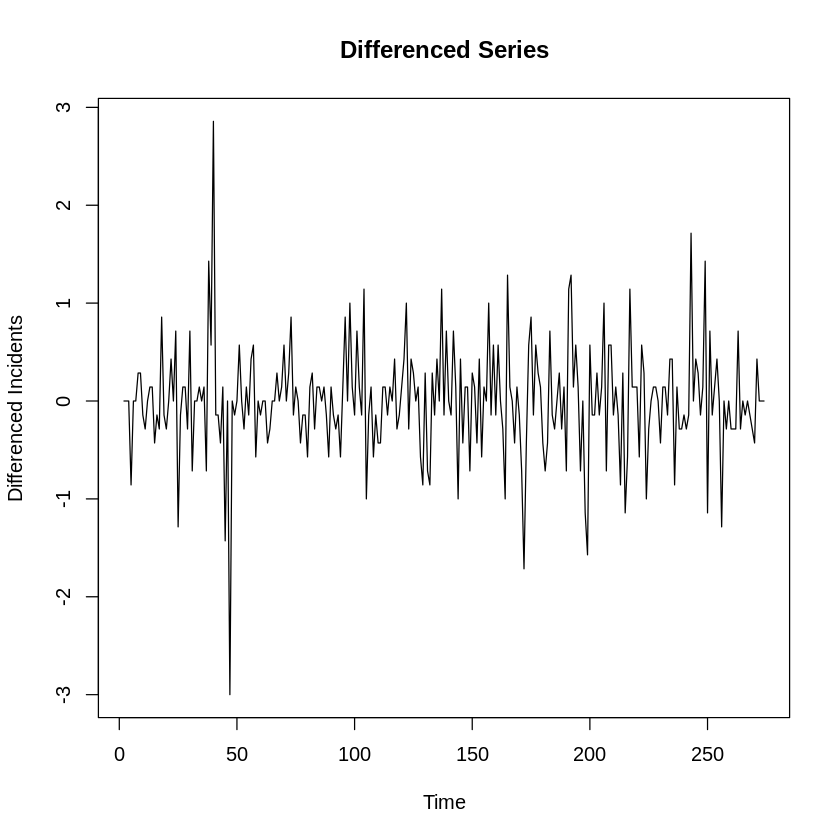

In [37]:
# Differencing to make the series stationary
incidents_data_diff <- diff(incidents_data)
plot(incidents_data_diff, main = "Differenced Series", ylab = "Differenced Incidents", xlab = "Time")

In [38]:
# Stationarity Tests
adf.test(incidents_data_diff)
kpss.test(incidents_data_diff)

Warning message in adf.test(incidents_data_diff):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  incidents_data_diff
Dickey-Fuller = -11.19, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(incidents_data_diff):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  incidents_data_diff
KPSS Level = 0.015338, Truncation lag parameter = 5, p-value = 0.1


AIC for ARIMA(1,1,0): 467.9654 
AIC for ARIMA(0,1,1): 468.1053 
AIC for ARIMA(1,1,1): 458.3957 
AIC for ARIMA(2,1,0): 467.1691 
AIC for ARIMA(0,1,2): 466.2511 
AIC for ARIMA(2,1,2): 418.4978 

	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 100.36, df = 9, p-value < 2.2e-16

Model df: 1.   Total lags used: 10



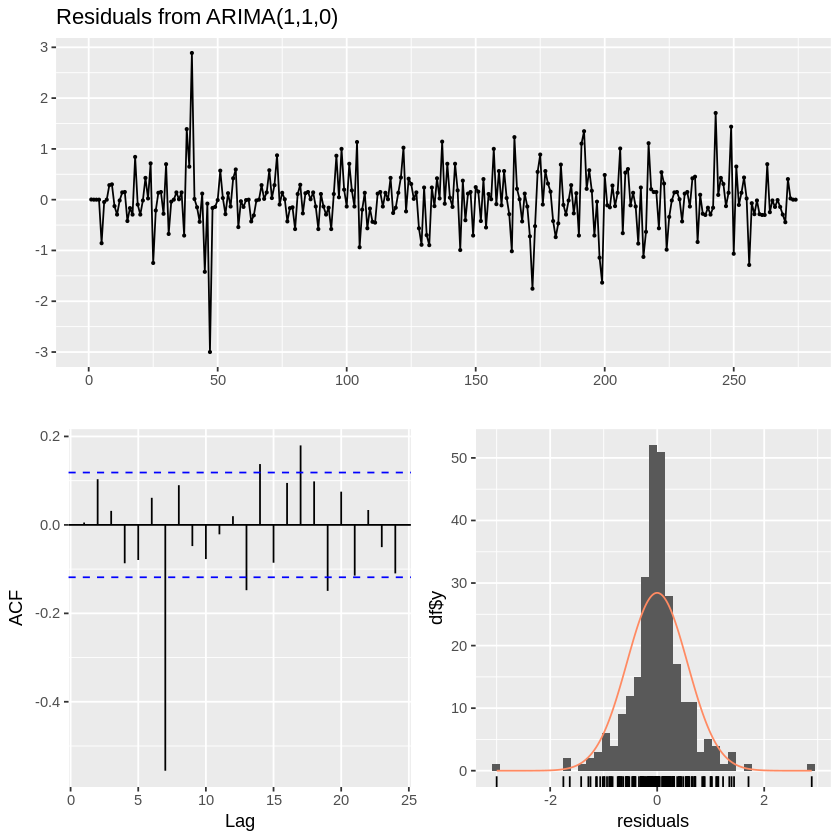


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)
Q* = 101.46, df = 9, p-value < 2.2e-16

Model df: 1.   Total lags used: 10



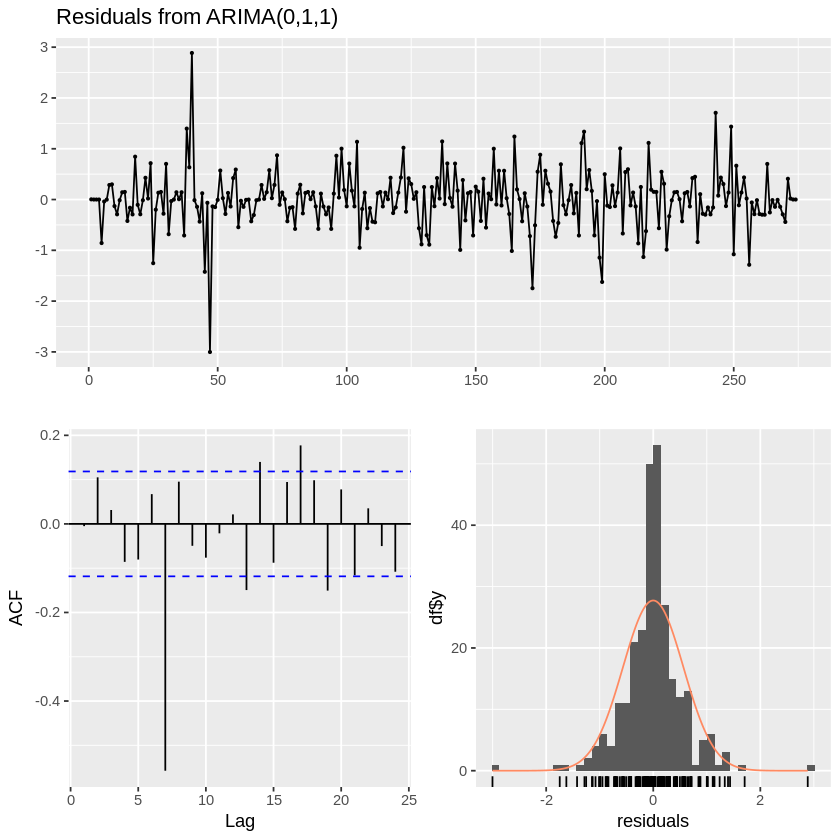


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)
Q* = 102.99, df = 8, p-value < 2.2e-16

Model df: 2.   Total lags used: 10



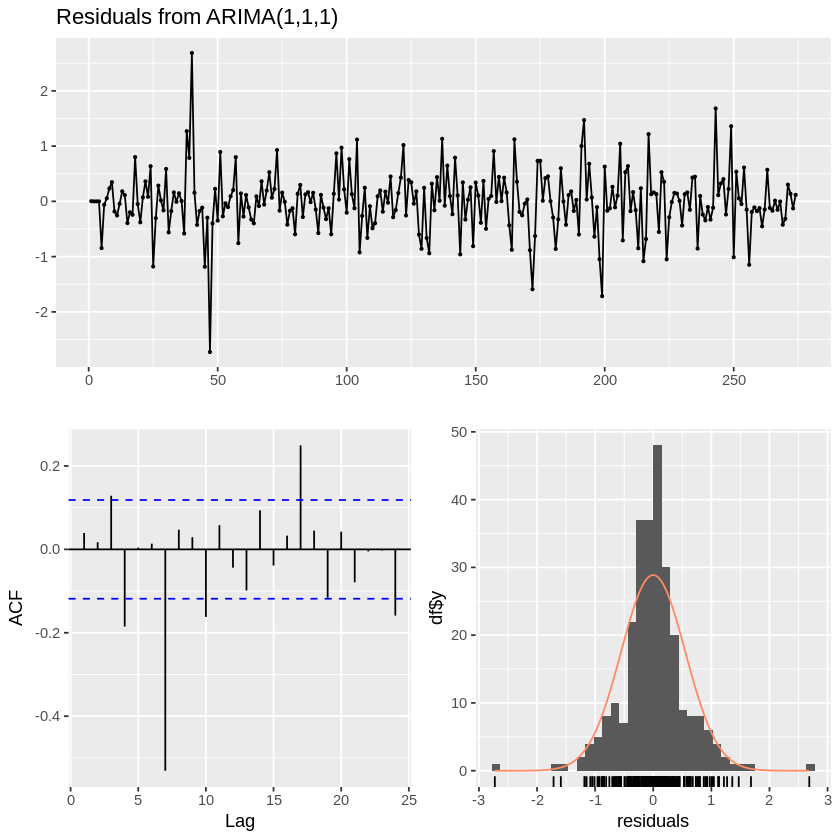


	Ljung-Box test

data:  Residuals from ARIMA(2,1,0)
Q* = 98.105, df = 8, p-value < 2.2e-16

Model df: 2.   Total lags used: 10



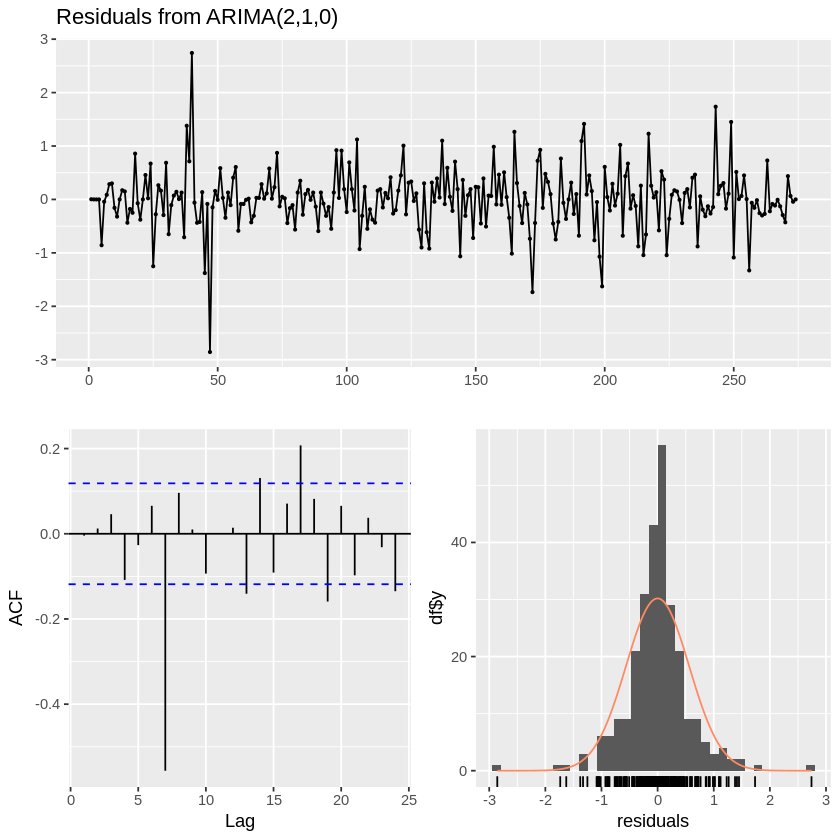


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2)
Q* = 95.378, df = 8, p-value < 2.2e-16

Model df: 2.   Total lags used: 10



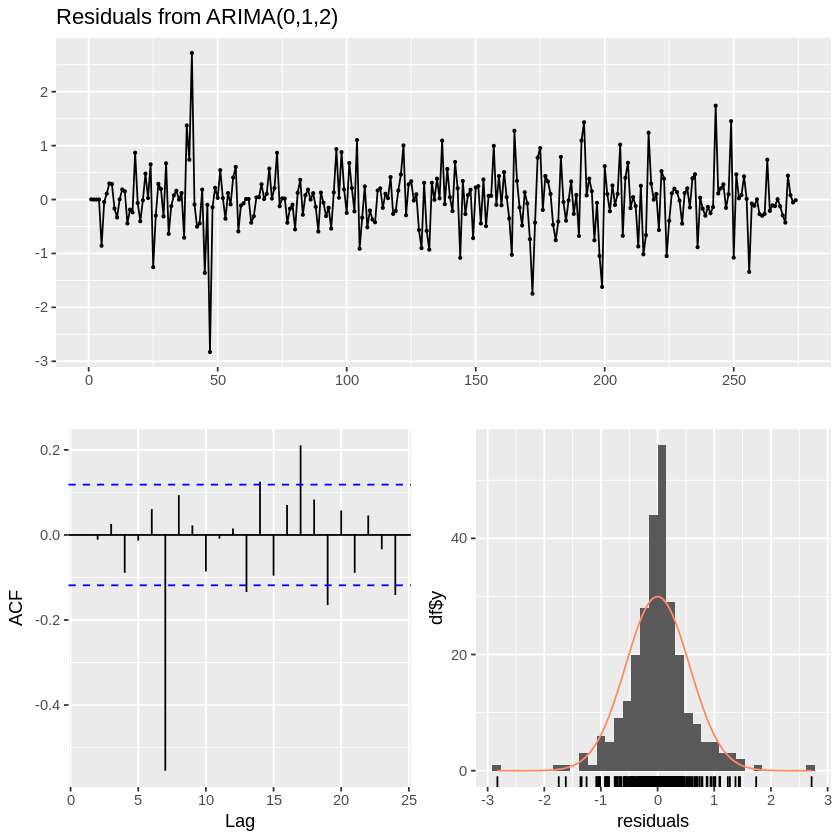


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)
Q* = 66.519, df = 6, p-value = 2.111e-12

Model df: 4.   Total lags used: 10



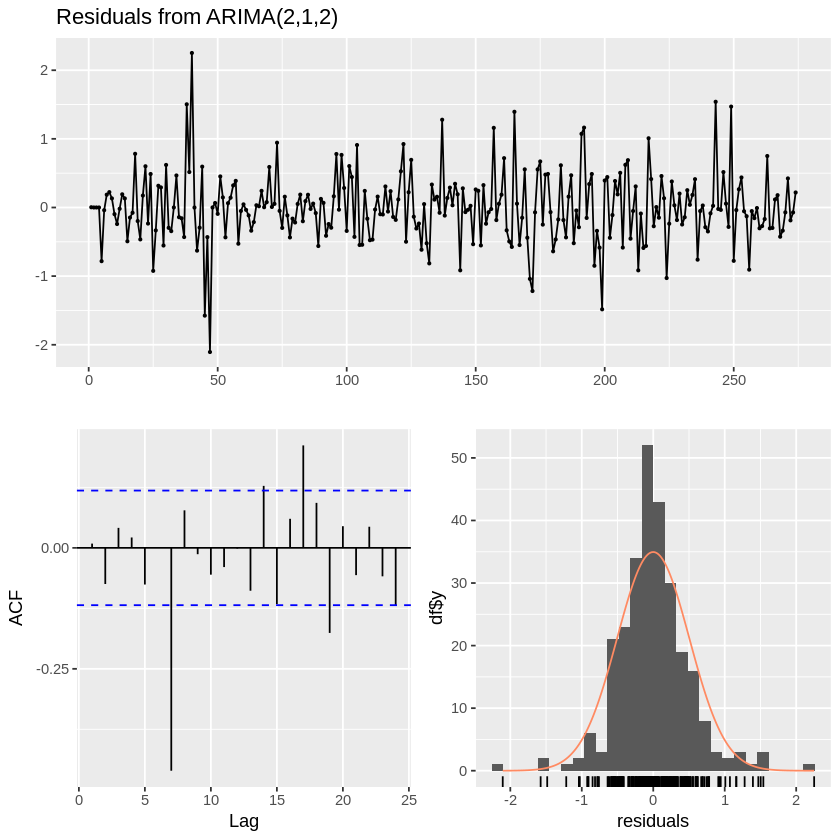

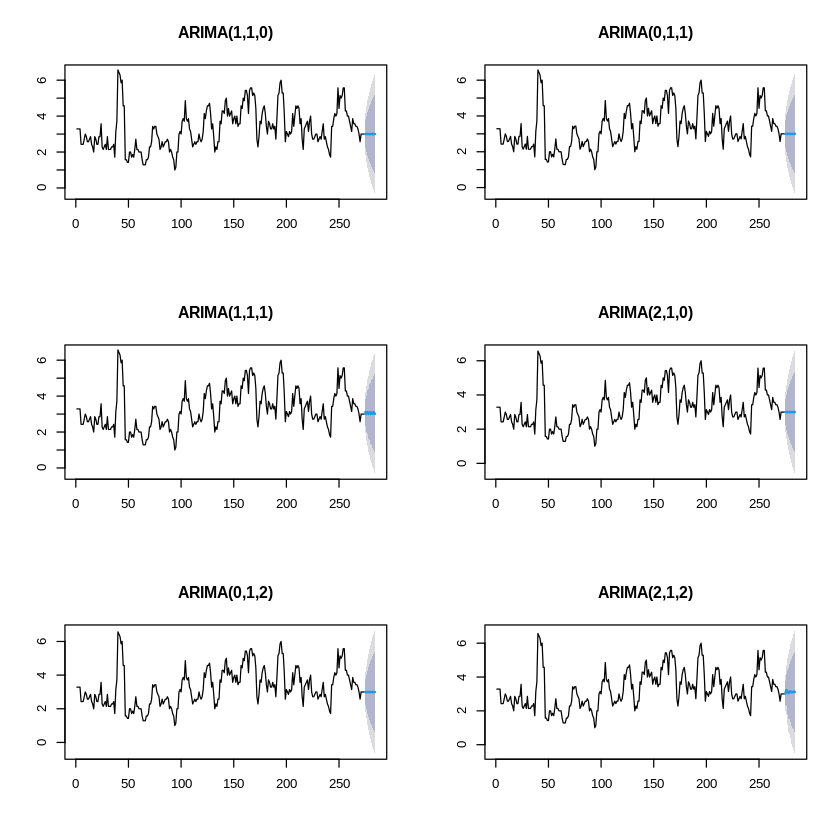

In [39]:
library(forecast)

# Fit ARIMA models with specified orders
model_110 <- Arima(incidents_data, order = c(1, 1, 0))
model_011 <- Arima(incidents_data, order = c(0, 1, 1))
model_111 <- Arima(incidents_data, order = c(1, 1, 1))
model_210 <- Arima(incidents_data, order = c(2, 1, 0))
model_012 <- Arima(incidents_data, order = c(0, 1, 2))
model_212 <- Arima(incidents_data, order = c(2, 1, 2))

# Compare models using AIC
cat("AIC for ARIMA(1,1,0):", AIC(model_110), "\n")
cat("AIC for ARIMA(0,1,1):", AIC(model_011), "\n")
cat("AIC for ARIMA(1,1,1):", AIC(model_111), "\n")
cat("AIC for ARIMA(2,1,0):", AIC(model_210), "\n")
cat("AIC for ARIMA(0,1,2):", AIC(model_012), "\n")
cat("AIC for ARIMA(2,1,2):", AIC(model_212), "\n")

# Check residual diagnostics for all models
checkresiduals(model_110)
checkresiduals(model_011)
checkresiduals(model_111)
checkresiduals(model_210)
checkresiduals(model_012)
checkresiduals(model_212)

# Plot forecasts for comparison
par(mfrow = c(3, 2))  # Arrange plots in 3 rows and 2 columns
plot(forecast(model_110, h = 10), main = "ARIMA(1,1,0)")
plot(forecast(model_011, h = 10), main = "ARIMA(0,1,1)")
plot(forecast(model_111, h = 10), main = "ARIMA(1,1,1)")
plot(forecast(model_210, h = 10), main = "ARIMA(2,1,0)")
plot(forecast(model_012, h = 10), main = "ARIMA(0,1,2)")
plot(forecast(model_212, h = 10), main = "ARIMA(2,1,2)")


Series: incidents_data 
ARIMA(1,1,1) 

Coefficients:
          ar1     ma1
      -0.9744  0.9261
s.e.   0.0237  0.0367

sigma^2 = 0.309:  log likelihood = -226.2
AIC=458.4   AICc=458.48   BIC=469.22

Training set error measures:
                        ME      RMSE       MAE       MPE    MAPE     MASE
Training set -0.0008497383 0.5528229 0.3837757 -1.687743 12.6905 1.010187
                   ACF1
Training set 0.03934533

Series: incidents_data 
ARIMA(1,1,1) 

Coefficients:
          ar1     ma1
      -0.9744  0.9261
s.e.   0.0237  0.0367

sigma^2 = 0.309:  log likelihood = -226.2
AIC=458.4   AICc=458.48   BIC=469.22

Training set error measures:
                        ME      RMSE       MAE       MPE    MAPE     MASE
Training set -0.0008497383 0.5528229 0.3837757 -1.687743 12.6905 1.010187
                   ACF1
Training set 0.03934533

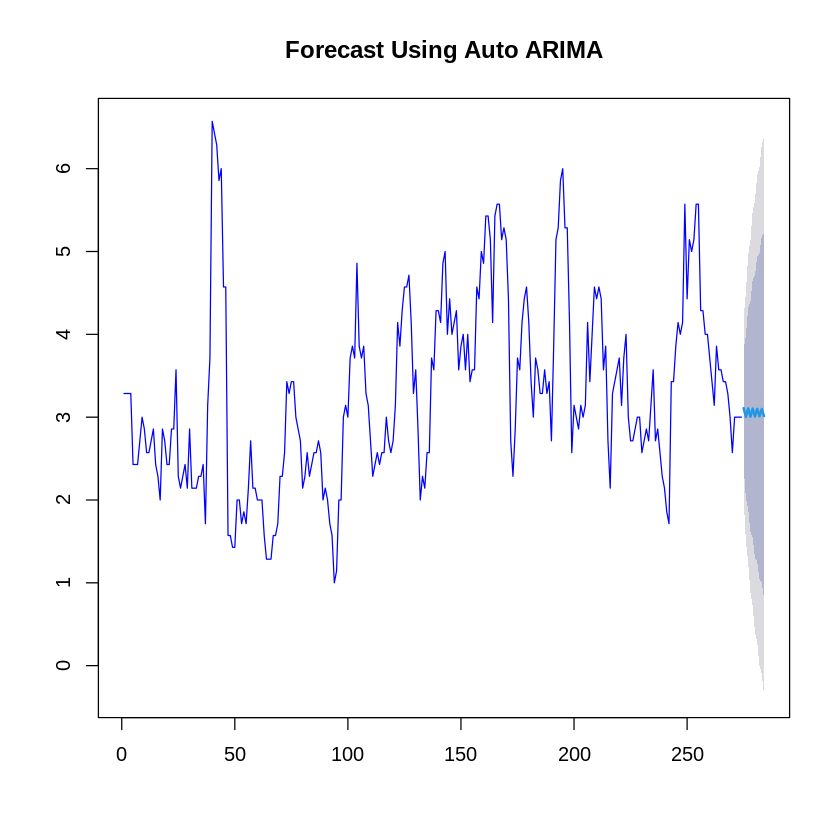

In [40]:
# Automatically find the best ARIMA model
best_model <- auto.arima(incidents_data, seasonal = FALSE)
summary(best_model)

# Summary of the best model
summary(best_model)

# Forecast using the best ARIMA model
forecast_auto <- forecast(best_model, h = 10)
plot(forecast_auto, main = "Forecast Using Auto ARIMA", col = "blue")


In [41]:
# Train/test split for evaluation
train <- head(incidents_data, -10)
test <- tail(incidents_data, 10)

In [43]:
# Refit ARIMA(1,1,1) on training data and forecast
model_111_train <- Arima(train, order = c(1, 1, 1))
forecast_111 <- forecast(model_111_train, h = 10)

In [44]:
# Evaluate accuracy
accuracy(forecast_111$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.5308035,0.5964498,0.5308035,-17.88813,17.88813,0.6150621,2.595451


In [45]:
# Plot ARIMA(1,1,1) forecast vs actual test data
test_ts <- ts(test, start = length(train) + 1, frequency = 1)

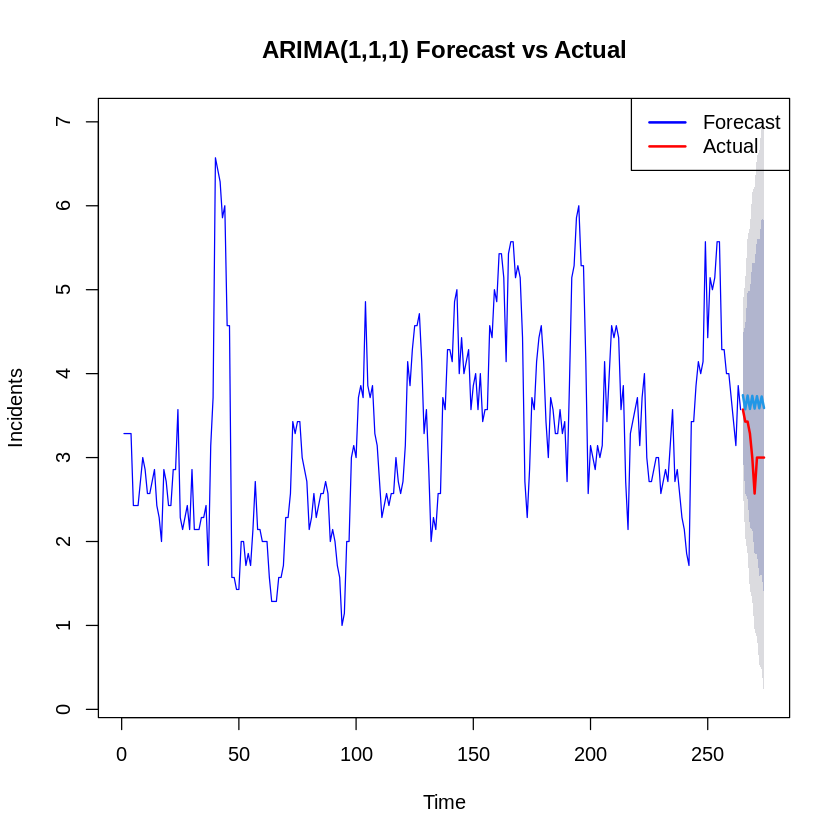

In [46]:
plot(forecast_111, main = "ARIMA(1,1,1) Forecast vs Actual", col = "blue", xlab = "Time", ylab = "Incidents")
lines(test_ts, col = "red", lwd = 2)
legend("topright", legend = c("Forecast", "Actual"), col = c("blue", "red"), lwd = 2)